# Model-Based Curation Tutorial: Applying Pre-trained Models on Sorting Analyzer

## Overview

This comprehensive tutorial demonstrates how to use machine learning classifiers for automated curation of spike-sorted neural data. You'll learn to download and apply pre-trained models from Hugging Face to classify unit quality using SpikeInterface's powerful analysis framework.


## Tutorial Structure

This tutorial follows a systematic workflow:
1. **Setup and Imports**: Configure environment and load necessary packages
2. **Model Loading**: Download and examine pre-trained classification models  
3. **Data Preparation**: Generate synthetic data with required quality metrics
4. **Model Application**: Apply models to classify unit quality automatically
5. **Performance Evaluation**: Compare predictions with human labels
6. **Confidence Analysis**: Analyze prediction reliability for workflow optimization

Let's begin by setting up our environment and importing the required packages.

## Step 1: Environment Setup and Package Imports

First, we'll import all necessary packages and configure our environment for optimal performance.

In [5]:
# Essential imports for data handling and visualization
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# SpikeInterface imports for neurophysiology data analysis
import spikeinterface as si
import spikeinterface.widgets as sw

# Machine learning imports for model evaluation
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

print("✓ Standard packages imported successfully")
print(f"✓ SpikeInterface version: {si.__version__}")

si.set_global_job_kwargs(n_jobs=4)
# Configure matplotlib for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 10

✓ Standard packages imported successfully
✓ SpikeInterface version: 0.102.3


In [4]:
# UnitRefine import 
try:
    from UnitRefine.scripts.model_based_curation import load_model, auto_label_units
    print("✓ UnitRefine imported successfully")
except ImportError:
    # If UnitRefine is not installed, add the local path
    import sys
    # Navigate to the directory containing the UnitRefine folder
    current_path = Path.cwd()
    unitrefine_root = current_path.parent.parent.parent  # Go to project root
    sys.path.append(str(unitrefine_root))
    
    try:
        from UnitRefine.scripts.model_based_curation import load_model, auto_label_units
        print("✓ UnitRefine imported from local path")
    except ImportError:
        print("❌ Could not import UnitRefine. Please check installation or path.")
        print(f"   Attempted path: {unitrefine_root}")
        print("   Alternative: Install via 'pip install UnitRefine' or check SpikeInterface integration")
        
# Alternative import (if integrated with SpikeInterface)
# from spikeinterface.curation import load_model, auto_label_units

✓ UnitRefine imported from local path


## Step 2: Loading Pre-trained Models

### Understanding Model Sources

UnitRefine supports loading pre-trained models from multiple sources:
- **Hugging Face Hub**: Public repository of community models
- **Local Storage**: Previously downloaded or custom-trained models

The `load_model` function handles these sources automatically and provides model metadata including feature requirements, training details, and performance metrics.

### Downloading from Hugging Face

Let's download a pre-trained model from [Hugging Face](https://huggingface.co/). This example uses a toy tetrode model specifically designed for demonstration purposes.

In [16]:
# Download and load pre-trained model from Hugging Face
print("Downloading pre-trained model from Hugging Face...")
try:
    model, model_info = load_model(
        repo_id="SpikeInterface/toy_tetrode_model",
        trusted=['numpy.dtype']
    )
    print("✓ Model loaded successfully!")
    print(f"✓ Model type: {type(model).__name__}")
    print(f"✓ Number of features required: {len(model.feature_names_in_)}")
    
except Exception as e:
    print(f"❌ Error loading model: {str(e)}")
    print("   Check internet connection and Hugging Face access")
    raise

✓ Model loaded successfully!
✓ Model type: Pipeline
✓ Number of features required: 34
✓ Model loaded successfully!
✓ Model type: Pipeline
✓ Number of features required: 34


### Examining the Model

The loaded model is a scikit-learn Pipeline that contains preprocessing steps and the trained classifier. Let's explore its structure and requirements.

In [17]:
# Display model information
print("Model Structure:")
print(f"Pipeline steps: {[step[0] for step in model.steps]}")
print(f"Final estimator: {model.steps[-1][1].__class__.__name__}")

Model Structure:
Pipeline steps: ['imputer', 'scaler', 'classifier']
Final estimator: RandomForestClassifier


### Understanding Feature Requirements

Each model requires specific quality metrics to make predictions. Let's examine what metrics this model expects and understand their significance in spike sorting quality assessment.

In [18]:
# Display required features (metrics)
required_features = model.feature_names_in_
print("Required Quality Metrics:")

print(f"\nTotal features required: {len(required_features)}")

# Display model metadata if available
if 'training_info' in model_info:
    print(f"\nModel Training Information:")
    training_info = model_info['training_info']
    if 'dataset_size' in training_info:
        print(f"Training dataset size: {training_info['dataset_size']} units")
    if 'accuracy' in training_info:
        print(f"Training accuracy: {training_info['accuracy']:.1%}")
        
print(f"\nLabel conversion: {model_info.get('label_conversion', 'Not specified')}")

Required Quality Metrics:

Total features required: 34

Label conversion: {'1': 'good', '0': 'bad'}


## Step 3: Data Preparation and Analysis Setup

### Understanding SortingAnalyzer Requirements

To use this model, we need to create a `SortingAnalyzer` object with all required metrics computed. This involves:
1. **Recording object**: loading electrophysiology data
2. **Spike Sorting object**: Running a spike sorter and loading the output 
3. **Metric Computation**: Calculating quality and template metrics


For this tutorial, we'll generate synthetic data that mimics real tetrode recordings.

**Key Resources:**
- [Recordings Documentation](https://spikeinterface.readthedocs.io/en/latest/modules/extractors.html)
- [Spike Sorting Guide](https://spikeinterface.readthedocs.io/en/latest/modules/sorters.html) 
- [SortingAnalyzer Tutorial](https://spikeinterface.readthedocs.io/en/latest/tutorials/core/plot_4_sorting_analyzer.html)
- [Extensions Overview](https://spikeinterface.readthedocs.io/en/latest/modules/postprocessing.html)

In [19]:
# Generate synthetic tetrode data matching the model's training domain
print("Generating synthetic tetrode recording and sorting...")

# Create synthetic data with parameters matching model training
recording, sorting = si.generate_ground_truth_recording(
    num_channels=4,        # Tetrode configuration
    seed=4,               # Reproducible results
    num_units=10,         # Moderate number of units
    sampling_frequency=30000,  # Standard sampling rate
    durations=[60],       # 60 seconds of data
    
)

print(f"✓ Generated recording: {recording.get_num_channels()} channels, "
      f"{recording.get_sampling_frequency()} Hz, {recording.get_total_duration():.1f}s")
print(f"✓ Generated sorting: {sorting.get_num_units()} units")

# Create SortingAnalyzer for comprehensive analysis
print("\nCreating SortingAnalyzer and computing extensions...")
sorting_analyzer = si.create_sorting_analyzer(
    sorting=sorting, 
    recording=recording,
    sparse=False  # Compute on all channels for small tetrode
)

# Compute all extensions required by the model
extensions_to_compute = [
    'noise_levels',      # Background noise characterization
    'random_spikes',     # Spike sampling for analysis
    'waveforms',         # Spike waveform extraction  
    'templates',         # Average waveform templates
    'spike_locations',   # Spatial localization of spikes
    'spike_amplitudes',  # Amplitude distributions
    'correlograms',      # Auto/cross-correlograms
    'principal_components',  # PCA analysis
    'quality_metrics',   # Standard quality metrics
    'template_metrics'   # Template-based metrics
]

sorting_analyzer.compute(extensions_to_compute)
print(f"✓ Computed {len(extensions_to_compute)} analysis extensions")

# Display summary statistics
units = sorting_analyzer.unit_ids
print(f"\nDataset Summary:")
print(f"Unit IDs: {units}")

Generating synthetic tetrode recording and sorting...
✓ Generated recording: 4 channels, 30000.0 Hz, 60.0s
✓ Generated sorting: 10 units

Creating SortingAnalyzer and computing extensions...


noise_level (workers: 4 processes):   0%|          | 0/20 [00:00<?, ?it/s]

compute_waveforms (workers: 4 processes):   0%|          | 0/60 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/10 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/10 [00:00<?, ?it/s]

Compute : spike_locations + spike_amplitudes (workers: 4 processes):   0%|          | 0/60 [00:00<?, ?it/s]

noise_level (workers: 4 processes):   0%|          | 0/20 [00:00<?, ?it/s]

calculate_pc_metrics:   0%|          | 0/10 [00:00<?, ?it/s]

✓ Computed 10 analysis extensions

Dataset Summary:
Unit IDs: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


### Validating Metric Compatibility

Before applying the model, let's verify that our computed metrics match the model's feature requirements. This is a crucial validation step to ensure successful prediction.

In [23]:
# Validate that computed metrics match model requirements
quality_metrics = list(sorting_analyzer.get_extension('quality_metrics').get_data().keys())
template_metrics = list(sorting_analyzer.get_extension('template_metrics').get_data().keys())
all_computed_metrics = quality_metrics + template_metrics

print("Computed Metrics:")
print(f"Quality metrics ({len(quality_metrics)}): {quality_metrics[:5]}...")  # Show first 5
print(f"Template metrics ({len(template_metrics)}): {template_metrics[:5]}...")

print(f"\nModel Requirements vs. Computed Metrics:")
required_features = set(model.feature_names_in_)
computed_features = set(all_computed_metrics)

# Check compatibility
missing_features = required_features - computed_features
extra_features = computed_features - required_features

if len(missing_features) == 0:
    print("✓ All required metrics are available!")
    compatibility = True
else:
    print(f"❌ Missing {len(missing_features)} required metrics: {missing_features}")
    compatibility = False

if len(extra_features) > 0:
    print(f"ℹ️  {len(extra_features)} additional metrics computed (not used by model)")

print(f"\nCompatibility check: {'PASSED' if compatibility else 'FAILED'}")
print(f"Feature match: {np.all(sorted(all_computed_metrics) == sorted(model.feature_names_in_))}")

Computed Metrics:
Quality metrics (27): ['num_spikes', 'firing_rate', 'presence_ratio', 'snr', 'isi_violations_ratio']...
Template metrics (7): ['peak_to_valley', 'peak_trough_ratio', 'half_width', 'repolarization_slope', 'recovery_slope']...

Model Requirements vs. Computed Metrics:
✓ All required metrics are available!

Compatibility check: PASSED
Feature match: True


## Step 4: Applying the Model for Automated Curation

### Making Predictions

Now we can use our trained model to automatically classify unit quality. The `auto_label_units` function handles feature extraction, preprocessing, and prediction, returning both class labels and confidence scores for each unit.

In [28]:
# Apply model to classify unit quality automatically
print("Applying pre-trained model to classify units...")

labels = auto_label_units(
    sorting_analyzer=sorting_analyzer,
    repo_id="SpikeInterface/toy_tetrode_model",
    trusted=['numpy.dtype']
)

print("✓ Model predictions completed successfully!")
print(f"✓ Classified {len(labels)} units")

# Display prediction summary
label_counts = labels.iloc[:, 0].value_counts()
print(f"\nPrediction Summary:")
for label, count in label_counts.items():
    percentage = (count / len(labels)) * 100
    print(f"  {label}: {count} units ({percentage:.1f}%)")
        

labels

Applying pre-trained model to classify units...
✓ Model predictions completed successfully!
✓ Classified 10 units

Prediction Summary:
  good: 9 units (90.0%)
  bad: 1 units (10.0%)
✓ Model predictions completed successfully!
✓ Classified 10 units

Prediction Summary:
  good: 9 units (90.0%)
  bad: 1 units (10.0%)


,prediction,probability
0,good,0.747560
1,good,0.903640
2,good,0.904640
3,good,0.763560
4,good,0.819560
5,good,0.613703
6,good,0.912640
7,bad,0.580440
8,good,0.867560
9,good,0.923640


### Visualizing Classification Results

Let's examine the waveform templates of units with different quality classifications to understand what the model is detecting. We'll compare units with high confidence scores for both 'good' and 'bad' classifications.

Best 'good' unit: 9 (confidence: 92.4%)
Best 'bad' unit: 7 (confidence: 58.0%)

Comparing templates for units ['9', '7']


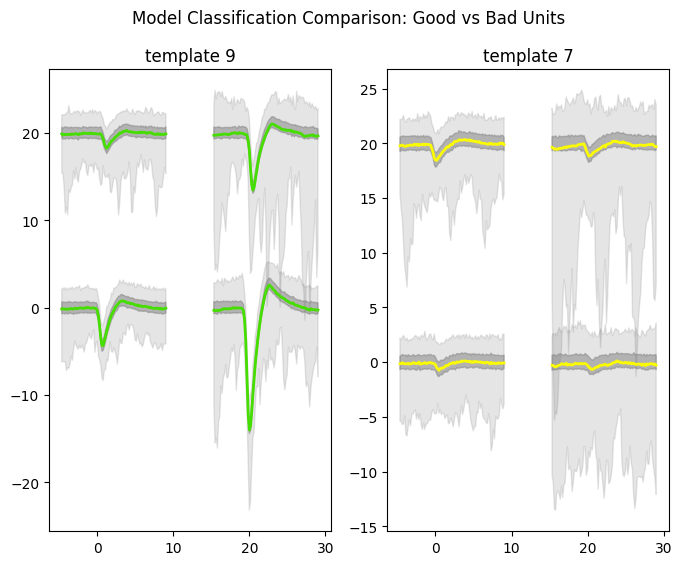

In [29]:
# Identify representative units for visualization
good_units = labels[labels.iloc[:, 0] == 'good']
bad_units = labels[labels.iloc[:, 0] == 'bad']

# Find highest confidence examples of each class
if len(good_units) > 0:
    best_good_unit = good_units.iloc[:, 1].idxmax()
    good_confidence = good_units.loc[best_good_unit, good_units.columns[1]]
    print(f"Best 'good' unit: {best_good_unit} (confidence: {good_confidence:.1%})")

if len(bad_units) > 0:
    best_bad_unit = bad_units.iloc[:, 1].idxmax()
    bad_confidence = bad_units.loc[best_bad_unit, bad_units.columns[1]]
    print(f"Best 'bad' unit: {best_bad_unit} (confidence: {bad_confidence:.1%})")

# Plot template comparison
units_to_plot = []
if len(good_units) > 0:
    units_to_plot.append(best_good_unit)
if len(bad_units) > 0:
    units_to_plot.append(best_bad_unit)

if len(units_to_plot) >= 2:
    print(f"\nComparing templates for units {units_to_plot}")
    sw.plot_unit_templates(sorting_analyzer, unit_ids=units_to_plot)
    plt.suptitle("Model Classification Comparison: Good vs Bad Units")
    plt.show()
else:
    print("Only one class detected - plotting all available units")
    sw.plot_unit_templates(sorting_analyzer, unit_ids=sorting_analyzer.unit_ids[:4])
    plt.show()

## Step 5: Model Performance Evaluation

### Understanding Model Decisions

The visualization above shows the model's decision-making process. Typically, 'good' units have:
- Clear, consistent spike waveforms
- Appropriate amplitude and duration
- Low noise characteristics

'Bad' units often exhibit:
- Inconsistent or noisy waveforms  
- Unusual temporal dynamics
- Artifacts or multi-unit activity

### Comparing with Human Curation

To evaluate model performance objectively, we'll compare predictions against simulated human labels and analyze agreement patterns. This helps determine when to trust automated decisions versus requiring manual review.

In [27]:
# Display current predictions for reference
print("Current Model Predictions:")
print("=" * 40)
for unit_id in labels.index:
    pred_label = labels.loc[unit_id, labels.columns[0]]
    confidence = labels.loc[unit_id, labels.columns[1]]
    print(f"Unit {unit_id}: {pred_label} ({confidence:.1%} confidence)")

print(f"\nTotal units analyzed: {len(labels)}")

Current Model Predictions:
Unit 0: good (74.8% confidence)
Unit 1: good (90.4% confidence)
Unit 2: good (90.5% confidence)
Unit 3: good (76.4% confidence)
Unit 4: good (82.0% confidence)
Unit 5: good (61.4% confidence)
Unit 6: good (91.3% confidence)
Unit 7: bad (58.0% confidence)
Unit 8: good (86.8% confidence)
Unit 9: good (92.4% confidence)

Total units analyzed: 10


Human vs Model Comparison Setup:
Human labels (conservative curator): ['good', 'good', 'good', 'good', 'good', 'bad', 'good', 'bad', 'good', 'good']
Model predictions: ['good', 'good', 'good', 'good', 'good', 'good', 'good', 'bad', 'good', 'good']

Model Performance:
Balanced Accuracy: 75.0%


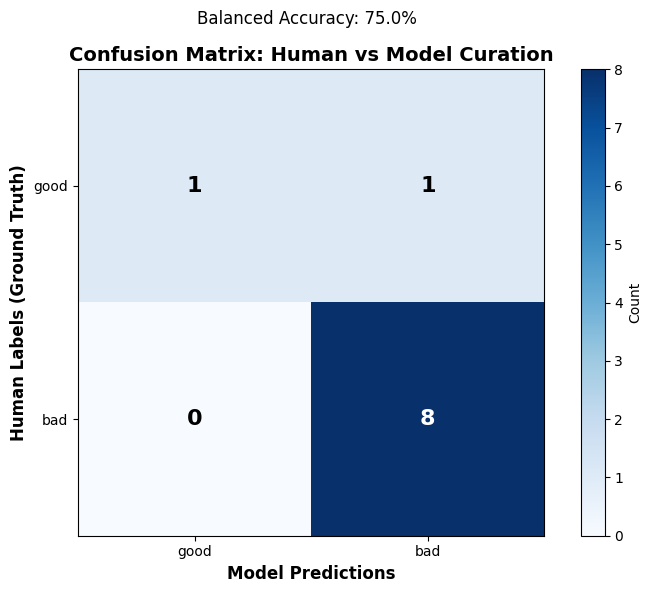


Detailed Performance Metrics:
Precision (good units): 88.9%
Recall (good units): 100.0%
False positive rate: 1/10 units (10.0%)


In [34]:
# Simulate conservative human curation for comparison
# (In practice, load from Phy: sorting_analyzer.sorting.get_property('quality'))
human_labels = ['good', 'good', 'good', 'good', 'good', 'bad', 'good', 'bad', 'good', 'good']

print("Human vs Model Comparison Setup:")
print("Human labels (conservative curator):", human_labels)

# Extract model predictions for analysis
model_predictions = [labels.iloc[i, 0] for i in range(len(labels))]
prediction_confidences = [labels.iloc[i, 1] for i in range(len(labels))]

print("Model predictions:", model_predictions)

# Create confusion matrix
conf_matrix = confusion_matrix(human_labels, model_predictions)
balanced_accuracy = balanced_accuracy_score(human_labels, model_predictions)

print(f"\nModel Performance:")
print(f"Balanced Accuracy: {balanced_accuracy:.1%}")

# Visualize confusion matrix with professional styling
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')

# Add value annotations
for (i, j), value in np.ndenumerate(conf_matrix):
    plt.annotate(str(value), xy=(j, i), ha='center', va='center', 
                color="white" if value > conf_matrix.max()/2 else "black", 
                fontsize=16, fontweight='bold')

# Formatting
label_conversion = model_info['label_conversion']
tick_labels = list(label_conversion.values())
plt.xlabel('Model Predictions', fontsize=12, fontweight='bold')
plt.ylabel('Human Labels (Ground Truth)', fontsize=12, fontweight='bold')
plt.xticks(ticks=[0, 1], labels=tick_labels)
plt.yticks(ticks=[0, 1], labels=tick_labels)
plt.title('Confusion Matrix: Human vs Model Curation', fontsize=14, fontweight='bold')
plt.suptitle(f'Balanced Accuracy: {balanced_accuracy:.1%}', fontsize=12)

# Add colorbar
plt.colorbar(label='Count')
plt.tight_layout()
plt.show()

# Calculate detailed metrics
true_positives = conf_matrix[1, 1]  # Good correctly identified as good
false_positives = conf_matrix[0, 1]  # Bad incorrectly identified as good  
false_negatives = conf_matrix[1, 0]  # Good incorrectly identified as bad
true_negatives = conf_matrix[0, 0]  # Bad correctly identified as bad

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

print(f"\nDetailed Performance Metrics:")
print(f"Precision (good units): {precision:.1%}")
print(f"Recall (good units): {recall:.1%}")
print(f"False positive rate: {false_positives}/{len(human_labels)} units ({false_positives/len(human_labels):.1%})")

## Step 6: Confidence-Based Workflow Optimization

### Understanding Prediction Confidence

Model confidence scores provide crucial information for optimizing curation workflows. High-confidence predictions can often be trusted for automated processing, while low-confidence cases should be flagged for manual review.

This analysis helps determine:
- **Confidence thresholds** for automated acceptance
- **Cases requiring manual review** based on uncertainty
- **Model reliability patterns** across different unit types

Confidence Analysis Setup:
Mean confidence: 80.4%
Confidence range: 58.0% - 92.4%
Overall agreement rate: 90.0%


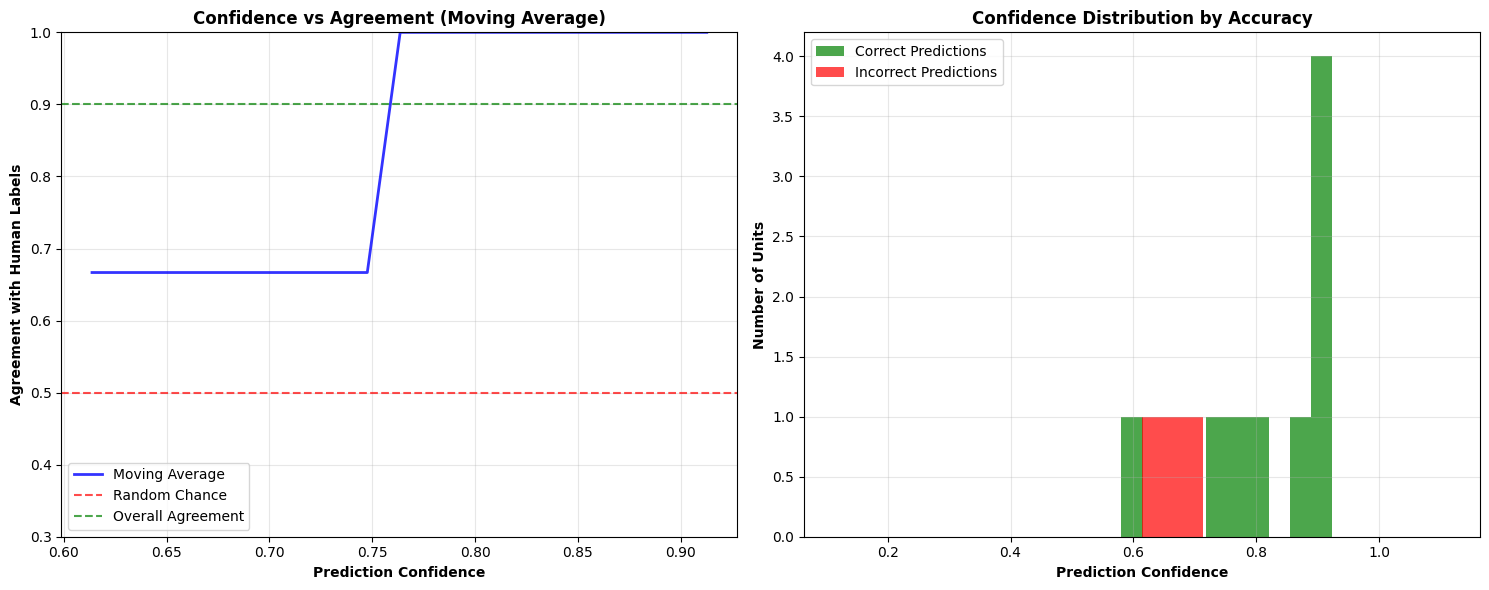


Workflow Recommendations:
High confidence (>80%): 6 units - suitable for automation
Low confidence (<60%): 1 units - require manual review
Medium confidence: 3 units - case-by-case decision


In [37]:
# Analyze relationship between prediction confidence and accuracy

def calculate_confidence_analysis(label_df, confidence_col='confidence', window_size=3):
    """Calculate moving average of prediction accuracy by confidence level."""
    
    # Create confidence deciles for grouping
    label_df[f'{confidence_col}_decile'] = pd.cut(
        label_df[confidence_col], 
        bins=10, 
        labels=False, 
        duplicates='drop'
    )
    
    # Calculate agreement by decile
    decile_agreement = label_df.groupby(f'{confidence_col}_decile')['agreement'].mean()
    
    # Sort by confidence for moving average
    label_df_sorted = label_df.sort_values(by=confidence_col)
    moving_avg_agreement = label_df_sorted['agreement'].rolling(
        window=window_size, 
        center=True
    ).mean()
    
    return label_df_sorted[confidence_col], moving_avg_agreement, decile_agreement

# Extract confidence scores and create analysis dataframe
confidences = sorting_analyzer.sorting.get_property('classifier_probability')

analysis_df = pd.DataFrame({
    'human_label': human_labels,
    'model_label': model_predictions,
    'confidence': confidences
}, index=sorting_analyzer.unit_ids)

# Calculate agreement between human and model labels
analysis_df['agreement'] = (analysis_df['human_label'] == analysis_df['model_label'])

print("Confidence Analysis Setup:")
print(f"Mean confidence: {analysis_df['confidence'].mean():.1%}")
print(f"Confidence range: {analysis_df['confidence'].min():.1%} - {analysis_df['confidence'].max():.1%}")
print(f"Overall agreement rate: {analysis_df['agreement'].mean():.1%}")

# Perform confidence analysis
conf_sorted, moving_avg, decile_stats = calculate_confidence_analysis(analysis_df, window_size=3)

# Create comprehensive confidence plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Moving average plot
ax1.plot(conf_sorted, moving_avg, 'b-', linewidth=2, label='Moving Average', alpha=0.8)
ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Random Chance')
ax1.axhline(y=analysis_df['agreement'].mean(), color='green', linestyle='--', 
           alpha=0.7, label='Overall Agreement')
ax1.set_xlabel('Prediction Confidence', fontweight='bold')
ax1.set_ylabel('Agreement with Human Labels', fontweight='bold')
ax1.set_title('Confidence vs Agreement (Moving Average)', fontweight='bold')
ax1.set_ylim(0.3, 1)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Confidence distribution by agreement
agreement_true = analysis_df[analysis_df['agreement'] == True]['confidence']
agreement_false = analysis_df[analysis_df['agreement'] == False]['confidence']

ax2.hist(agreement_true, bins=10, alpha=0.7, label='Correct Predictions', color='green')
ax2.hist(agreement_false, bins=10, alpha=0.7, label='Incorrect Predictions', color='red')
ax2.set_xlabel('Prediction Confidence', fontweight='bold')
ax2.set_ylabel('Number of Units', fontweight='bold')
ax2.set_title('Confidence Distribution by Accuracy', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print confidence-based recommendations
high_conf_threshold = 0.8
low_conf_threshold = 0.6

high_conf_units = analysis_df[analysis_df['confidence'] > high_conf_threshold]
low_conf_units = analysis_df[analysis_df['confidence'] < low_conf_threshold]

print(f"\nWorkflow Recommendations:")
print(f"High confidence (>{high_conf_threshold:.0%}): {len(high_conf_units)} units - suitable for automation")
print(f"Low confidence (<{low_conf_threshold:.0%}): {len(low_conf_units)} units - require manual review")
print(f"Medium confidence: {len(analysis_df) - len(high_conf_units) - len(low_conf_units)} units - case-by-case decision")